## Playing Atari with Deep Reinforcement Learning 리뷰

Arari는 강화학습을 사용한 high-dimensionla sensoey를 입력받아 제어정책을 학습하는 딥러닝 모델이다. 이 모델은 CNN + 번형된 Q-learning을 사용하여 학습하였다. 

딥러닝을 강화학습에 적용하는데 3가지 문제점이 있다.
1. DL은 label이 존재하는 많은 train데이터를 필요로 하지만 RL은 그런것이 없다.
   RL은 sprase,noisy, delayed한 신호같은 scalar값을 통해 학습해야한다.
2. DL의 데이터들은 독립적이지만, RL의 데이터는 time series data이기 떄문에 상관관계를 가지고 있다.
3. RL 데이터의 분포가 일정하지 않다.
   알고리즘이 새로운 behavior을 배울때마다 분포가 변하게되어 딥러닝(데이터분포고정)과 충돌하여 문제가 될 수 있다.

#### Background

agent가 환경(E)과 상호작용한다고 생각해보자
1. agent는 각 time-step마다 A = {1, . . . , K}중에서 at를 선택한다
2. Emulator로 전달되어 state와 game score를 수정한다
3. reward(rt)를 return한다

** 하지만, agent는 전체적인 상황을 관찰하기 어렵기 때문에 action과 observation의  sequence를 고려해야한다<br>
** 따라서, 각 sequence가 별개의 상태이고 크고 유한한 MDP에 강화학습방법을 적용할것이다<br>
** The goal of the agent is to interact with the emulator by selecting actions in a way that maximises
future rewards

* (return at time t) Rt = ∑r^(t‘−t)rt‘
(T는 종료되는 시간)

* (최적의 action-value fun.)Q∗(s,a)=maxπE[Rt|st=s,at=α,π] -- Bellman Equation을 따른다


* Bellman Equation(1) <br>
Q∗(s,a)=E(s′∼E)[r+γmaxa′Q∗(s′,a′) ∣∣ s,a]<br>
r+γQ∗(s′,a′)의 expected value를 최대화하는 것을 식으로 표현한 것이다.

* Bellman Equation(2) -- Q-network <br>
Li(θi)=Es,a∼ρ(⋅)[(yi−Q(s,a;θi))2],where, yi=Es′∼E[r+γmaxa′Q(s′,a′;θi−1) ∣∣ s,a]<br>
neural network function approximator로 weight θ 를 사용하는 것을 말한다<br>
Q-network 반복때마다 바뀌는 손실함수Li(θi)를 최소화시키면서 학습한다

* Bellman Equation(3) -- Q-network <br>
∇θiLi(θi)=Es,a∼ρ(⋅);s′∼E[(r+γmaxa′Q(s′,a′;θi−1)−Q(s,a;θi))∇θiQ(s,a;θi)]<br>
전체기대치를 계산하는 대신 stochastic gradient descent를 통해 손실함수를 최적화하는 것이 계산적으로 편리하다

* 이 알고리즘은 model-free : E를 고려하지 않는다
* off-policy : Behavior Policy와 Learning Policy를 별도로 두고사용한다

#### Related Work -- TD-gammon
* Q-learning과 비슷하게 model-free구조이다
* value function을 하나의 hidden layer를 가진 multi-layer perceptron로 계산한다
* 이 시도는 특정경우에서만 작동하는 특별한 경우였다
* Q-Learning, non-linear function approximators일때 Q-network가 발산하기 때문에 수렴을 위해서 linear function approximator, better convergence guarantees가 있어야한다

Related Work -- DL과 LR 융합
* 환경 E 추정 --> Deep neural networks사용
* value function & policy 추정 --> restricted Boltzmann machines
* Q-learning의 발산 문제 --> gradient temporal-difference

Neural fitted Q-Learning(NFQ) 
* RPROP알고리즘 사용한다(parameter 업데이트를 위해)
* deep autoencoder사용한다(저차원 표현을 학습)

Arari에서는...
* Stochastic Gradient Descent를 사용한다(반복하기 위해 필요한 계산 줄임)--> scale-up
* reinforcement learning end-to-end, directly from the visual inputs

#### Deep Reinforcement Learning
* 목표 : to connect a reinforcement learning algorithm to a deep neural network which operates directly on RGB images and efficiently process training data by using stochastic gradient updates.
* 알고리즘1 : Experience reply<br>
  reply memory에 마지막 N개의 experience tuples만을 저장, D로부터 무작위로 추출하여 update를 한다. 항상 제한된 크기N의 버퍼에 최근trasition을 덮는다는 한계가 존재한다.

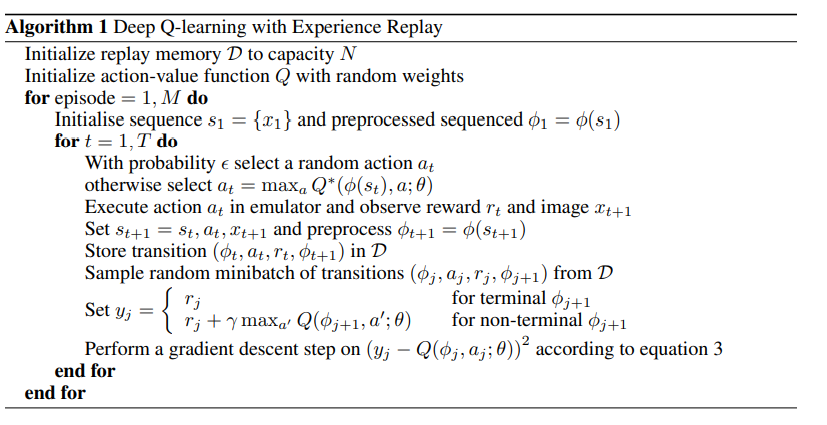

#### Preprocessing 
* 128color를 가진 210*160픽셀이미지를 다루는것은 많은 계산을 필요하므로 bisc preprocessing step을 적용한다
* RGB표현 --> gray-scale, 110*84이미지로 down-sampling
* 84*84로 잘라내어 final input값을 추출 --> GPU처리

#### Model Architecture
* input은 φ에의해 생성된 84*84*4의 이미지이다
* 첫번째 hidden layer는 16 8*8로 컨볼루션(stirde 4), rectifier nonlinearity적용한다
* 두번째 hidden layer는 32 4*4로 컨볼루션(stirde 2), rectifier nonlinearity적용한다
* 마지막 hidden layer는 fully-connected, 256개의 유닛으로 이루어진다
* Output layer는 fully-connected linear layer이다

#### Experiments<br>
** 7개의 게임 모두에게 동일한 network architecture사용, 알고리즘 및 하이퍼파라미터를 setting
1. reward 고정 : 1,-1,0
2. RMSProp algorithm with minibatches of size 32, The behavior policy during training was e-greedy with e annealed linearly from 1 to 0.1 over the first million frames, and fixed at 0.1 thereafter.
3. a simple frame-skipping technique : agent가 모든 k에서 actions를 보고 선택(여기서는 k=3으로 처리)


#### Training and Stability
* RL에서는 학습중에 agent의 과정을 정확히 측저하는 것은 어렵다 
* 이논문에서 평가척도는 agent가 수집해온 reward를 train중에 주기적으로 계산한다

#### Conclusion 
* RL을 위한 새로운 Deep Learning Model을 소개
* raw pixel들을 input으로 사용하여 Control Policy를 학습하는 것이 가능함을 증명 
* RL을 위한 deep network의 학습을 쉽게하기 위해 Stochastic Minibatch Update + Experience Replay Memory인 Q-learning을 소개
* 테스트를 거친 결과, architecture 나 hyperparameters의 변화없이 7개 중에서 6개의 게임에서 좋은 성과를 냄